## First stage 
### Downloaded the sample stackoverflow data from hugging face with 13224 records.
#### The URL for dataset : hf://datasets/mlfoundations-dev/stackexchange_devops/data/train-00000-of-00001.parquet
> **Following steps are taken:**
> - Create Virtual environment , in this case I used python 3.12
> - From top right select kernel 3.12

In [1]:
pip install datasets


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: /Users/badalsingh/Workspace/LLMs/LLMOps/myenv3.12/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
from datasets import load_dataset
import pandas as pd

In [3]:
df = pd.read_parquet("hf://datasets/mlfoundations-dev/stackexchange_devops/data/train-00000-of-00001.parquet")
df.head(5)
len(df)

13224

In [4]:
# Add a new column combining both questions and answers
df["myspec"]="Question: "+df["instruction"]+" Answer:  " + df["completion"]
# check first 4 rows for 3 colums in dataframe df
df.head(4)

,instruction,completion,conversations,myspec
0,My build process packages my application in a ...,"Yes, your deployment revision can use a `.nupk...","[{'from': 'human', 'value': 'My build process ...",Question: My build process packages my applica...
1,So here is your job role:\n\nYou help in desig...,"Based on the job role you've described, a good...","[{'from': 'human', 'value': 'So here is your j...",Question: So here is your job role:\n\nYou hel...
2,Amazon S3 has an option of cross-region replic...,Amazon S3's cross-region replication (CRR) is ...,"[{'from': 'human', 'value': 'Amazon S3 has an ...",Question: Amazon S3 has an option of cross-reg...
3,I've had some very interesting conversations t...,"In a DevOps environment, where cross-functiona...","[{'from': 'human', 'value': 'I've had some ver...",Question: I've had some very interesting conve...


In [5]:
## For testing my script, I am minimizing the token cost to embedding model and just using 50 records from dataframe.
## These fifty records will be written into a json file
df50=df[:50]

In [6]:
## Write this dataframe df new created column "myspec" into a json file.
## File name : devops_data.json

json_data=df50["myspec"].to_json(orient='records')
with open ("devops_data50.json","w") as devops_data:
    devops_data.write(json_data)

In [7]:
import json
with open("devops_data50.json","r") as data_f50:
    data_50=json.load(data_f50)
    print(len(data_50))

50


## 2nd stage:
#### Load JSON document with 50 records only, to not exceed quota of embedding model
#### Use the json file created with only 50 records of "myspec" column from dataframe.


#### Use my devops json data to answer related questions.
#### https://learn.microsoft.com/en-us/azure/ai-services/openai/how-to/switching-endpoints
#### import modules/libraries from rquirements.txt

In [10]:
#pip install -r requirements.txt


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: /Users/badalsingh/Workspace/LLMs/LLMOps/myenv3.12/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [8]:
import os
from openai import AzureOpenAI
import sys

from langchain.document_loaders import JSONLoader

In [9]:
json_loader = JSONLoader(file_path="devops_data50.json", jq_schema=".",text_content=False)
json_loaded_data=json_loader.load()
## Read metdata from JSonLoader of langchain
d=json_loaded_data[0]
print(d.metadata)
## print content of this page loaded
print(json_loaded_data[0].page_content[0:5000])

{'source': '/Users/badalsingh/Workspace/LLMs/LLMOps/devops_data50.json', 'seq_num': 1}
["Question: My build process packages my application in a .nupkg instead of a .zip. \nAssuming my .nupkg contains a correctly-implemented appspec.yml and is otherwise appropriately bundled, can my deployment revision use it?\n Answer:  Yes, your deployment revision can use a `.nupkg` file, provided that it contains a correctly-implemented `appspec.yml` file and is otherwise appropriately packaged according to the deployment service's requirements. \n\nFor example, if you are using AWS CodeDeploy, the `.nupkg` file needs to include the `appspec.yml` file, which defines how the application should be deployed, along with any other files needed for the deployment. The key is that the deployment service must support the type of package you are using, and you have to ensure that the contents of the `.nupkg` are correctly structured for deployment.\n\nMake sure to test the deployment with a small revision t

## 3rd stage
#### Split document into smaller chunks

In [ ]:
## For testing I am using recursive text splitter, there are other options as well in langchain :
### https://python.langchain.com/v0.1/docs/modules/data_connection/document_transformers/

In [10]:
from langchain.text_splitter import RecursiveCharacterTextSplitter, CharacterTextSplitter

In [11]:
## Test recursive text splitter with chunk size and chunk overlap
chunk_size=2500
chunk_overlap=250
sample_text = "My name is somthing you won't remember, until you know this."
r_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
r_splitter.split_text(sample_text)

["My name is somthing you won't remember, until you know this."]

In [12]:
r_splitter_new = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap,separators=["Question:","\n\n","\n"])

In [13]:
## Split the data from json file created in stage 2 above.
my_data = r_splitter_new.split_documents(json_loaded_data)
len(my_data)

50

## 4th stage
### Vectorization and embedding
### All chunks of data we obtained from splitting should be indexed , so that we can use the data to answer questions.
### to perform this we will use embedding and vector stores

In [14]:
#from langchain.embeddings.azure_openai import AzureOpenAIEmbeddings
from langchain_openai import AzureOpenAIEmbeddings

In [15]:
%env AZURE_OPENAI_ENDPOINT=https://ai-myraghub246415217390.openai.azure.com/openai/deployments/text-embedding-ada-002/embeddings?api-version=2023-05-15
%env AZURE_OPENAI_API_KEY=B33zpvwBj9Y4Lk4PF8RDZpNnsBA6vsKmHpyH376vcYPfJH84x4VFJQQJ99BBACHYHv6XJ3w3AAAAACOGILfZ
az_openai_embedding = AzureOpenAIEmbeddings(model="text-embedding-ada-002")

env: AZURE_OPENAI_ENDPOINT=https://ai-myraghub246415217390.openai.azure.com/openai/deployments/text-embedding-ada-002/embeddings?api-version=2023-05-15
env: AZURE_OPENAI_API_KEY=B33zpvwBj9Y4Lk4PF8RDZpNnsBA6vsKmHpyH376vcYPfJH84x4VFJQQJ99BBACHYHv6XJ3w3AAAAACOGILfZ


In [16]:
#openai_embedding = OpenAIEmbeddings()
az_openai_embedding = AzureOpenAIEmbeddings()

In [17]:
### Sample embeddings
# sample texts for embedding and embedding comparisions
s1="I like fruits."
s2="I like apples."
s3="Sun rises from the east."
emb1 = az_openai_embedding.embed_query(s1)
emb2 = az_openai_embedding.embed_query(s2)
emb3 = az_openai_embedding.embed_query(s3)
import numpy as np
### compare likeliness of embeddings
print(np.dot(emb1,emb2))
print(np.dot(emb1,emb3))
print(np.dot(emb2,emb3))

0.9424148941143409
0.7456183639607952
0.7402937622251249


In [18]:
from langchain.vectorstores import Chroma


In [19]:
db_dir = "./docs/chroma3/"
!rm -rf ./docs/chroma3


In [20]:
vectordb = Chroma.from_documents(documents=my_data, embedding=az_openai_embedding, persist_directory=db_dir)

In [21]:
print(vectordb._collection.count())

50


In [22]:
docs=vectordb.similarity_search("Amazon S3 has an option of cross-region replication",k=2)
len(docs)
print(docs[0].page_content)

Question: Amazon S3 has an option of cross-region replication which should be pretty fault-tolerant against region/zone outages.\nDoes that mean those who are ranting about the outage did not make use of this aspect?\nOr is that cross-region replication is not completely fool-proof and would not have helped?\n Answer:  Amazon S3's cross-region replication (CRR) is indeed a powerful feature that allows for data to be automatically replicated across different AWS regions. This can enhance fault tolerance and data availability, especially in the case of regional outages. However, there are several considerations to keep in mind regarding its effectiveness during outages:\n\n1. **Configuration**: Users need to enable and correctly configure cross-region replication. If an organization does not have CRR set up, they would not benefit from this feature during an outage.\n\n2. **Replication Lag**: CRR is not instantaneous. There can be replication lag, meaning that any changes made to data ma

### Now time to use Chat GPT LLM model to use for question anwering
### First setup envrionment vraibles for AZURE_OPENAI_API_KEY, AZURE_OPENAI_ENDPOINT,OPENAI_API_VERSION


In [23]:
%env AZURE_OPENAI_ENDPOINT=https://ai-myraghub246415217390.openai.azure.com/openai/deployments/gpt-35-turbo/chat/completions?api-version=2025-01-01-preview
%env AZURE_OPENAI_API_KEY=B33zpvwBj9Y4Lk4PF8RDZpNnsBA6vsKmHpyH376vcYPfJH84x4VFJQQJ99BBACHYHv6XJ3w3AAAAACOGILfZ
%env OPENAI_API_VERSION=2025-01-01-preview
%env AZURE_OPENAI_DEPLOYMENT_NAME=gpt-35-turbo

env: AZURE_OPENAI_ENDPOINT=https://ai-myraghub246415217390.openai.azure.com/openai/deployments/gpt-35-turbo/chat/completions?api-version=2025-01-01-preview
env: AZURE_OPENAI_API_KEY=B33zpvwBj9Y4Lk4PF8RDZpNnsBA6vsKmHpyH376vcYPfJH84x4VFJQQJ99BBACHYHv6XJ3w3AAAAACOGILfZ
env: OPENAI_API_VERSION=2025-01-01-preview
env: AZURE_OPENAI_DEPLOYMENT_NAME=gpt-35-turbo


In [24]:
#from langchain.llms import AzureOpenAI
from langchain_openai import AzureChatOpenAI
#from langchain.retrievers.self_query.base import SelfQueryRetriever
#from langchain.chains.query_constructor.base import AttributeInfo

In [25]:
llm = AzureChatOpenAI(temperature=0,name="gpt-35-turbo")

In [26]:
#from langchain.chains import RetrievalQA
from langchain.chains import (create_retrieval_chain,create_history_aware_retriever)
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains.mapreduce import MapReduceDocumentsChain
from langchain_core.prompts import (ChatPromptTemplate, MessagesPlaceholder)

In [27]:
llm.invoke("Tell me a joke")

AIMessage(content="Why couldn't the bicycle stand up by itself?\n\nBecause it was two tired!", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 11, 'total_tokens': 27, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': 'fp_0165350fbb', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}, id='run-fe

In [28]:
#llm.invoke("Tell me a joke")
#Stuff technique
#need to check other 3 techniques like Map_reduce, Refine and map_rerank


system_prompt = (
    "Use the given context to answer the question. "
    "If you don't know the answer, say you don't know. "
    "Use three sentence maximum and keep the answer concise. "
    "Context: {context}"
)
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "{input}"),
    ]
)
print(vectordb._collection.count())
question_answer_chain = create_stuff_documents_chain(llm, prompt)

retriever=vectordb.as_retriever()
chain = create_retrieval_chain(retriever, question_answer_chain)
query="what info does the doc contain regarding aws s3."
chain.invoke({"input": query})["answer"]


50


'The document contains information about managing data in Amazon S3, including strategies for handling HIPAA-compliant data, ordering physical backups using AWS Snowball, ensuring site availability during S3 outages, and managing secrets securely in serverless applications. It covers topics such as encryption, cross-region replication, CDN usage, multi-cloud strategies, secrets management with AWS Secrets Manager and Parameter Store, and best practices for securing and accessing data in S3.'

In [30]:
pip install -qU langgraph


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: /Users/badalsingh/Workspace/LLMs/LLMOps/myenv3.12/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [31]:
from langchain.memory.buffer import ConversationBufferMemory
memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)
#question_answer_chain_chat = create_stuff_documents_chain(llm, prompt,memory)


### https://python.langchain.com/api_reference/langchain/chains/langchain.chains.conversational_retrieval.base.ConversationalRetrievalChain.html

### Contex
# Contextualize question
contextualize_q_system_prompt = (
    "Given a chat history and the latest user question "
    "which might reference context in the chat history, "
    "formulate a standalone question which can be understood "
    "without the chat history. Do NOT answer the question, just "
    "reformulate it if needed and otherwise return it as is."
)

contextualize_q_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", contextualize_q_system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)

history_aware_retriever = create_history_aware_retriever(
    llm, retriever, contextualize_q_prompt
)

# Answer question
qa_system_prompt = (
    "You are an assistant for question-answering tasks."
    "Use the following pieces of retrieved context to answer the question."
    "If you don't know the answer, just say that you don't know." 
    "Use three sentences maximum and keep the answer concise."
    "Context: {context}"
) 

qa_prompt = ChatPromptTemplate.from_messages(
    [
        ("system",qa_system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human","{input}"),
    ]
)
question_answer_chain = create_stuff_documents_chain(llm, qa_prompt) 

rag_chain = create_retrieval_chain(
    history_aware_retriever, question_answer_chain
)
#chat_history = []
#query="what info does the doc contain regarding aws s3."
#rag_chain.invoke({"input":query,"chat_history":chat_history})



In [33]:
from langchain_core.messages import HumanMessage

chat_history = []

query="what info does the doc contain regarding aws s3."
resp1 = rag_chain.invoke({"input":query,"chat_history":chat_history})
print(resp1["answer"])

chat_history.extend([HumanMessage(content=query), resp1["answer"]])

second_question = "what strategies it mentions to backup data?"
ai_msg_2 = rag_chain.invoke({"input": second_question, "chat_history": chat_history})

print(ai_msg_2)

The document contains information about managing data in Amazon S3, including strategies for handling HIPAA-compliant data, ordering physical backups using AWS Snowball, ensuring site availability during S3 outages, and securely managing secrets in AWS Lambda functions without committing them to source control. It also discusses best practices for encryption, access controls, monitoring, and redundancy when working with S3 in AWS architectures.
{'input': 'what strategies it mentions to backup data?', 'chat_history': [HumanMessage(content='what info does the doc contain regarding aws s3.', additional_kwargs={}, response_metadata={}), 'The document contains information about managing data in Amazon S3, including strategies for handling HIPAA-compliant data, ordering physical backups using AWS Snowball, ensuring site availability during S3 outages, and securely managing secrets in AWS Lambda functions without committing them to source control. It also discusses best practices for encrypti

In [34]:
query="what strategies it mentions to backup data."
rag_chain.invoke({"input":query,"chat_history":chat_history})

{'input': 'what strategies it mentions to backup data.',
 'chat_history': [HumanMessage(content='what info does the doc contain regarding aws s3.', additional_kwargs={}, response_metadata={}),
  'The document contains information about managing data in Amazon S3, including strategies for handling HIPAA-compliant data, ordering physical backups using AWS Snowball, ensuring site availability during S3 outages, and securely managing secrets in AWS Lambda functions without committing them to source control. It also discusses best practices for encryption, access controls, monitoring, and redundancy when working with S3 in AWS architectures.'],
 'context': [Document(metadata={'seq_num': 1, 'source': '/Users/badalsingh/Workspace/LLMs/LLMOps/devops_data50.json'}, page_content='Question: What is a good strategy to keep my site online when S3 goes offline?\\nIf S3 US East 1 goes offline, how should I have my app configured/structured to prevent that taking my entire site offline?\\nWhat are the

In [35]:
#question="Amazon S3 has an option of cross-region replication"
#result = qa_chain({"query": question})
#result["result"]
query="What does it say about exporting data?"
chain.invoke({"input": query})["answer"]

'To export data from Amazon S3 to a physical drive and have it shipped to your address, you would typically use the AWS Snowball service, not Amazon Glacier. AWS Snowball is a data transfer service that allows you to securely transfer large amounts of data using physical devices. You can set up a job in AWS Snowball to export the data from S3, choose the destination drive, transfer the data, and return the device to AWS for processing and shipping.'

In [120]:
pip install -U langsmith

  Attempting uninstall: langsmith
    Found existing installation: langsmith 0.3.1
    Uninstalling langsmith-0.3.1:
      Successfully uninstalled langsmith-0.3.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-community 0.3.16 requires langchain<0.4.0,>=0.3.16, but you have langchain 0.3.15 which is incompatible.

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: /Users/badalsingh/Workspace/LLMs/LLMOps/myenv3.12/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [132]:
#Using Langsmith
import os
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = "ls...0" # replace dots with your api key
os.environ["LANGCHAIN_PROJECT"] = "myllmproject1"
os.environ["OPENAI_API_KEY"] = "B33...LfZ"

In [135]:
from langsmith import utils
utils.tracing_is_enabled()

False

In [136]:
print(os.environ.get("OPENAI_API_KEY"))

B33zpvwBj9Y4Lk4PF8RDZpNnsBA6vsKmHpyH376vcYPfJH84x4VFJQQJ99BBACHYHv6XJ3w3AAAAACOGILfZ


## Creating Chatbot here

In [2]:
import os
from openai import AzureOpenAI
import sys

from langchain.document_loaders import JSONLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_openai import AzureOpenAIEmbeddings
from langchain.vectorstores import Chroma
from langchain_openai import AzureChatOpenAI

from langchain.chains import (create_retrieval_chain,create_history_aware_retriever)
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains.mapreduce import MapReduceDocumentsChain
from langchain_core.prompts import (ChatPromptTemplate, MessagesPlaceholder)
from langchain.memory.buffer import ConversationBufferMemory
from langchain_core.messages import HumanMessage

In [5]:
## Embedd and vectorize data
def load_data(file, k):
    # load documents
    json_loader = JSONLoader(file_path=file, jq_schema=".",text_content=False)
    documents=json_loader.load()
    
    # split documents
    chunk_size=2500
    chunk_overlap=250
    r_splitter_new = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap,separators=["Question:","\n\n","\n"])
    split_docs = r_splitter_new.split_documents(documents)
    
    # define embedding
    %env AZURE_OPENAI_ENDPOINT=https://ai-myraghub246415217390.openai.azure.com/openai/deployments/text-embedding-ada-002/embeddings?api-version=2023-05-15
    %env AZURE_OPENAI_API_KEY=B33zpvwBj9Y4Lk4PF8RDZpNnsBA6vsKmHpyH376vcYPfJH84x4VFJQQJ99BBACHYHv6XJ3w3AAAAACOGILfZ
    az_openai_embedding = AzureOpenAIEmbeddings(model="text-embedding-ada-002")
    # create vector database from data
    #db = DocArrayInMemorySearch.from_documents(docs, embeddings)
    db_dir1 = "./docs/chroma1/"

    #Remove comment from below vectordb statement when you wish to recreate db store on local disk
    vectordb = Chroma.from_documents(documents=split_docs, embedding=az_openai_embedding, persist_directory=db_dir1)
    # define retriever
    retriever = vectordb.as_retriever(search_type="similarity", search_kwargs={"k": k})
    # create a chatbot chain. Memory is managed externally.
    return retriever


    

In [6]:
retriever = load_data("devops_data50.json",4)

env: AZURE_OPENAI_ENDPOINT=https://ai-myraghub246415217390.openai.azure.com/openai/deployments/text-embedding-ada-002/embeddings?api-version=2023-05-15
env: AZURE_OPENAI_API_KEY=B33zpvwBj9Y4Lk4PF8RDZpNnsBA6vsKmHpyH376vcYPfJH84x4VFJQQJ99BBACHYHv6XJ3w3AAAAACOGILfZ


In [7]:
from langchain.chains import (create_retrieval_chain,create_history_aware_retriever)
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains.mapreduce import MapReduceDocumentsChain
from langchain_core.prompts import (ChatPromptTemplate, MessagesPlaceholder)
from langchain.memory.buffer import ConversationBufferMemory

In [13]:
def load_db(file, chain_type, k):
    %env AZURE_OPENAI_ENDPOINT=https://ai-myraghub246415217390.openai.azure.com/openai/deployments/gpt-35-turbo/chat/completions?api-version=2025-01-01-preview
    %env AZURE_OPENAI_API_KEY=B33zpvwBj9Y4Lk4PF8RDZpNnsBA6vsKmHpyH376vcYPfJH84x4VFJQQJ99BBACHYHv6XJ3w3AAAAACOGILfZ
    %env OPENAI_API_VERSION=2025-01-01-preview
    %env AZURE_OPENAI_DEPLOYMENT_NAME=gpt-35-turbo

    #setup for question answer
    llm = AzureChatOpenAI(temperature=0,name="gpt-35-turbo")
    
    #memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)
    #question_answer_chain_chat = create_stuff_documents_chain(llm, prompt,memory)
    ### https://python.langchain.com/api_reference/langchain/chains/langchain.chains.conversational_retrieval.base.ConversationalRetrievalChain.html

    ### Contex
    # Contextualize question
    contextualize_q_system_prompt = (
        "Given a chat history and the latest user question "
        "which might reference context in the chat history, "
        "formulate a standalone question which can be understood "
        "without the chat history. Do NOT answer the question, just "
        "reformulate it if needed and otherwise return it as is."
    )

    contextualize_q_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", contextualize_q_system_prompt),
            MessagesPlaceholder("chat_history"),
            ("human", "{input}"),
        ]
    ) 

    history_aware_retriever = create_history_aware_retriever(
        llm, retriever, contextualize_q_prompt
    )

    # Answer question
    qa_system_prompt = (
        "You are an assistant for question-answering tasks."
        "Use the following pieces of retrieved context to answer the question."
        "If you don't know the answer, just say that you don't know." 
        "Use three sentences maximum and keep the answer concise."
        "Context: {context}"
    ) 

    qa_prompt = ChatPromptTemplate.from_messages(
        [
            ("system",qa_system_prompt),
            MessagesPlaceholder("chat_history"),
            ("human","{input}"),
        ]
    )
    question_answer_chain = create_stuff_documents_chain(llm, qa_prompt) 
    
    rag_chain = create_retrieval_chain(
        history_aware_retriever, question_answer_chain
    )
    #chat_history = []
    #query="what info does the doc contain regarding aws s3."
    #rag_chain.invoke({"input":query,"chat_history":chat_history})
    qa=rag_chain
    return qa 

In [24]:
qa=load_db("devops_data50.json","stuff",2)
qa.invoke("Tell me a joke")
           

env: AZURE_OPENAI_ENDPOINT=https://ai-myraghub246415217390.openai.azure.com/openai/deployments/gpt-35-turbo/chat/completions?api-version=2025-01-01-preview
env: AZURE_OPENAI_API_KEY=B33zpvwBj9Y4Lk4PF8RDZpNnsBA6vsKmHpyH376vcYPfJH84x4VFJQQJ99BBACHYHv6XJ3w3AAAAACOGILfZ
env: OPENAI_API_VERSION=2025-01-01-preview
env: AZURE_OPENAI_DEPLOYMENT_NAME=gpt-35-turbo


ValueError: The input to RunnablePassthrough.assign() must be a dict.

In [10]:
pip install -qU panel


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: /Users/badalsingh/Workspace/LLMs/LLMOps/myenv3.12/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [14]:
import panel as pn
import param

class cbfs(param.Parameterized):
    chat_history = param.List([])
    answer = param.String("")
    db_query  = param.String("")
    db_response = param.List([])
    
    def __init__(self,  **params):
        super(cbfs, self).__init__( **params)
        self.panels = []
        self.loaded_file = "devops_data50.json"
        self.qa = load_db(self.loaded_file,"stuff", 4)
    
    def call_load_db(self, count):
        if count == 0 or file_input.value is None:  # init or no file specified :
            return pn.pane.Markdown(f"Loaded File: {self.loaded_file}")
        else:
            file_input.save("devops_data50.json")  # local copy
            self.loaded_file = file_input.filename
            button_load.button_style="outline"
            self.qa = load_db("devops_data50.json", "stuff", 4)
            button_load.button_style="solid"
        self.clr_history()
        return pn.pane.Markdown(f"Loaded File: {self.loaded_file}")

    def convchain(self, query):
        if not query:
            return pn.WidgetBox(pn.Row('User:', pn.pane.Markdown("", width=600)), scroll=True)
        result = self.qa.invoke({"question": query, "chat_history": self.chat_history})
        self.chat_history.extend([(query, result["answer"])])
        self.db_query = result["generated_question"]
        self.db_response = result["source_documents"]
        self.answer = result['answer'] 
        self.panels.extend([
            pn.Row('User:', pn.pane.Markdown(query, width=600)),
            pn.Row('ChatBot:', pn.pane.Markdown(self.answer, width=600, style={'background-color': '#F6F6F6'}))
        ])
        inp.value = ''  #clears loading indicator when cleared
        return pn.WidgetBox(*self.panels,scroll=True)

    @param.depends('db_query ', )
    def get_lquest(self):
        if not self.db_query :
            return pn.Column(
                pn.Row(pn.pane.Markdown(f"Last question to DB:", styles={'background-color': '#F6F6F6'})),
                pn.Row(pn.pane.Str("no DB accesses so far"))
            )
        return pn.Column(
            pn.Row(pn.pane.Markdown(f"DB query:", styles={'background-color': '#F6F6F6'})),
            pn.pane.Str(self.db_query )
        )

    @param.depends('db_response', )
    def get_sources(self):
        if not self.db_response:
            return 
        rlist=[pn.Row(pn.pane.Markdown(f"Result of DB lookup:", styles={'background-color': '#F6F6F6'}))]
        for doc in self.db_response:
            rlist.append(pn.Row(pn.pane.Str(doc)))
        return pn.WidgetBox(*rlist, width=600, scroll=True)

    @param.depends('convchain', 'clr_history') 
    def get_chats(self):
        if not self.chat_history:
            return pn.WidgetBox(pn.Row(pn.pane.Str("No History Yet")), width=600, scroll=True)
        rlist=[pn.Row(pn.pane.Markdown(f"Current Chat History variable", styles={'background-color': '#F6F6F6'}))]
        for exchange in self.chat_history:
            rlist.append(pn.Row(pn.pane.Str(exchange)))
        return pn.WidgetBox(*rlist, width=600, scroll=True)

    def clr_history(self,count=0):
        self.chat_history = []
        return 

env: AZURE_OPENAI_ENDPOINT=https://ai-myraghub246415217390.openai.azure.com/openai/deployments/gpt-35-turbo/chat/completions?api-version=2025-01-01-preview
env: AZURE_OPENAI_API_KEY=B33zpvwBj9Y4Lk4PF8RDZpNnsBA6vsKmHpyH376vcYPfJH84x4VFJQQJ99BBACHYHv6XJ3w3AAAAACOGILfZ
env: OPENAI_API_VERSION=2025-01-01-preview
env: AZURE_OPENAI_DEPLOYMENT_NAME=gpt-35-turbo


Column
    [0] Row
        [0] Markdown(str)
    [1] Tabs
        [0] Column
            [0] Row
                [0] TextInput(placeholder='Enter text here…')
            [1] Divider()
            [2] ParamFunction(function, _pane=WidgetBox, defer_load=False, height=300, loading_indicator=True)
            [3] Divider()
        [1] Column
            [0] ParamMethod(method, _pane=Column, defer_load=False)
            [1] Divider()
            [2] ParamMethod(method, _pane=Str, defer_load=False)
        [2] Column
            [0] ParamMethod(method, _pane=WidgetBox, defer_load=False)
            [1] Divider()
        [3] Column
            [0] Row
                [0] FileInput(accept='.json')
                [1] Button(button_type='primary', name='Load DB')
                [2] ParamFunction(function, _pane=Markdown, defer_load=False)
            [1] Row
                [0] Button(button_type='warning', name='Clear History')
                [1] Markdown(str)
            [2] Divider()
            [3] Row
                [0] Image(str, width=400)
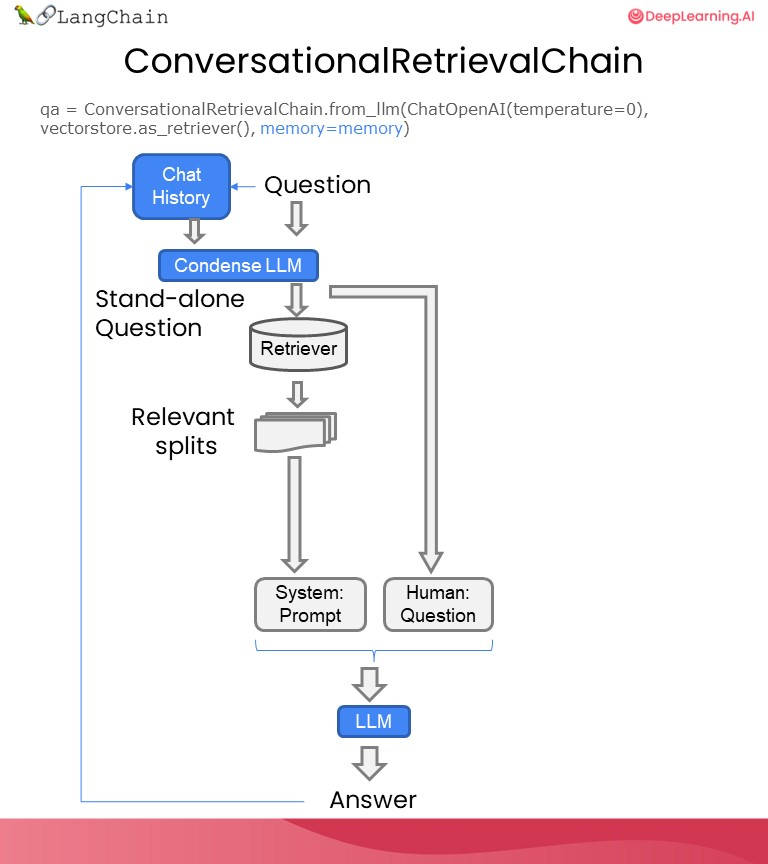

In [19]:
cb = cbfs()

file_input = pn.widgets.FileInput(accept='.json')
button_load = pn.widgets.Button(name="Load DB", button_type='primary')
button_clearhistory = pn.widgets.Button(name="Clear History", button_type='warning')
button_clearhistory.on_click(cb.clr_history)
inp = pn.widgets.TextInput( placeholder='Enter text here…')

bound_button_load = pn.bind(cb.call_load_db, button_load.param.clicks)
conversation = pn.bind(cb.convchain, inp) 

jpg_pane = pn.pane.Image( './img/convchain.jpg')

tab1 = pn.Column(
    pn.Row(inp),
    pn.layout.Divider(),
    pn.panel(conversation,  loading_indicator=True, height=300),
    pn.layout.Divider(),
)
tab2= pn.Column(
    pn.panel(cb.get_lquest),
    pn.layout.Divider(),
    pn.panel(cb.get_sources ),
)
tab3= pn.Column(
    pn.panel(cb.get_chats),
    pn.layout.Divider(),
)
tab4=pn.Column(
    pn.Row( file_input, button_load, bound_button_load),
    pn.Row( button_clearhistory, pn.pane.Markdown("Clears chat history. Can use to start a new topic" )),
    pn.layout.Divider(),
    pn.Row(jpg_pane.clone(width=400))
)
dashboard = pn.Column(
    pn.Row(pn.pane.Markdown('# ChatWithYourData_Bot')),
    pn.Tabs(('Conversation', tab1), ('Database', tab2), ('Chat History', tab3),('Configure', tab4))
)
pn.extension()
dashboard

In [16]:
import panel as pn
pn.extension()

# Create a simple panel
panel = pn.panel("Hello, Panel!")

# Display the panel
panel

Markdown(str)

In [ ]:
query="what info does the doc contain regarding aws s3."
resp1 = rag_chain.invoke({"input":query,"chat_history":chat_history})
print(resp1["answer"])

chat_history.extend([HumanMessage(content=question), resp1["answer"]])

second_question = "what strategies it mentions to backup data?"